# Supervised learning with random forests

Supervised learning is a machine learning problem where you can train a model to use features to predict a target variable based on prior examples.  This contrasts with unsupervised learning (eg. clustering), in which the data contains many features but no apparent target variable.

To get a taste for supervised learning, we'll build a random forest model to predict secondary school student behavior based on each student's attributes.

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

## 1. What is supervised learning?

In machine learning, you have a problem that needs to be solved, data related to the problem, and a computer.  In supervised learning, you're feeding data to the computer and training it to output the correct answer for a given set of inputs.

For example, let's say you love eating at Jin Ramen but hate waiting for a seat.  Let's also suppose that you have a dataset of 500 visits to Jin Ramen that contains information about the wait time for a table, the time of arrival, day of week, number of people in the party, etc.  You could train a supervised learning model on this dataset to predict wait time based on the other variables.  In the future, whenever you want ramen, you can input the values you know (the "features") to predict wait time (the "target") and decide whether to visit Jin Ramen or not.

Supervised learning usually involves regression and classification tasks.
- Regression: the target variable is continuous (eg. predicting the minutes you'll wait for a table)
- Classification: the target variable is a discrete value (eg. your waiting limit is 10 mins, so you train the model to output "0" if the wait time will be over 10 mins, and "1" if the wait time will be 10 mins or under)

## 2. Introduction to random forest

Random forest is a machine learning technique used for classification and regression tasks.  Random forest is an "ensemble" method because one model is composed of many decision trees, each of which produces an output; these outputs are then averaged to produce the random forest model's final prediction.

#### What's a decision tree?
A decision tree is a model that predicts the target value by running the inputs through a tree structure. 

Decision trees can handle numerical and categorical inputs.

This image is a simple decision tree for predicting whether a Titanic passenger "survived" or "died" (those are the target values in this classification task):

![decision tree](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

#### Back to random forest
A random forest model is composed of many (you decide how many) decision trees.  The idea is that one decision tree may not be accurate, but an entire forest of independent trees will provide higher accuracy because noise is canceled out and signal is strengthened.

When creating each tree, the random forest algorithm takes a sample of the data and the features to produce the best possible decision tree.  Once the entire forest is created and ready to make predictions, the random forest model runs an input down every tree, and outputs the average or majority decision of its trees.

Pros:
- High accuracy
- Fast to train
- Can handle many input variables, which relieves you of having to choose a subset of all variables before training the model
- Can work with numeric and categorical variables

Cons:
- Hard to interpret
- Prone to overfitting on noisy datasets
- Cannot deal with features or target values that do not exist in the training data

## 3. Random forest example
We're going to predict student alcohol consumption using a dataset about Portuguese students.  Take a moment to skim over the variables at http://archive.ics.uci.edu/ml/datasets/STUDENT+ALCOHOL+CONSUMPTION.

In [2]:
# Load in data from wherever you stored it
student_port = pd.read_csv('datasets/student-por.csv', sep = ';')

In [3]:
# Take a look at the first 5 rows
student_port.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [5]:
# Get the dataset's dimensions
student_port.shape

(649, 33)

Let's work with student_port because there are more examples.  We want to predict alcohol consumption based on all other variables (classification).

Cleaning:
- Correct data type for each column

In [6]:
# Check out the data type of each variable
student_port.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
school        649 non-null object
sex           649 non-null object
age           649 non-null int64
address       649 non-null object
famsize       649 non-null object
Pstatus       649 non-null object
Medu          649 non-null int64
Fedu          649 non-null int64
Mjob          649 non-null object
Fjob          649 non-null object
reason        649 non-null object
guardian      649 non-null object
traveltime    649 non-null int64
studytime     649 non-null int64
failures      649 non-null int64
schoolsup     649 non-null object
famsup        649 non-null object
paid          649 non-null object
activities    649 non-null object
nursery       649 non-null object
higher        649 non-null object
internet      649 non-null object
romantic      649 non-null object
famrel        649 non-null int64
freetime      649 non-null int64
goout         649 non-null int64
Dalc          649 no

In [7]:
# Most variables should be categorical, so let's list out the variables that are numeric and/or nominal
vars_num = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
            'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

In [11]:
# Let's put all the rf data into a new df, rf_data
rf_data = student_port[vars_num]

In [12]:
# But need to convert every categorical value into a number
# Label encoder converts to 0, 1, ... for alphabetically-sorted string values
for col in student_port.columns:
    if col not in vars_num:
        le = preprocessing.LabelEncoder()
        rf_data.loc[:, col] = le.fit_transform(student_port.loc[:, col])
        rf_data.loc[:,col] = rf_data.loc[:, col].astype('category')

In [13]:
# If we want to know the string value corresponding to a numerical category in X, go back to student_port
sorted(student_port['address'].unique())

['R', 'U']

In [14]:
student_port['Dalc'].value_counts()

1    451
2    121
3     43
5     17
4     17
Name: Dalc, dtype: int64

In [15]:
student_port['Walc'].value_counts()

1    247
2    150
3    120
4     87
5     45
Name: Walc, dtype: int64

In [16]:
# Let's create two categories of alcohol usage: 1-2 and 3-5
alc_mapping = {1: 0, 2: 0, 3: 1, 4: 1, 5:1}

In [17]:
rf_data['Dalc_mapped'] = rf_data['Dalc'].map(alc_mapping)

In [18]:
rf_data['Walc_mapped'] = rf_data['Walc'].map(alc_mapping)

### Modeling time

Supervised learning involves these general steps:

1. Split the data into training and test datasets.  Usually the split is anywhere from 60%/40% to 80%/20%.
2. Train a model on the training set.
3. Apply the model on the test set and compare the predicted results against the actual values to evaluate the model's performance.
    - As needed, iterate on the model to improve its performance (beware of overfitting!)
    - Look into the model to understand what it's doing, and gain some insight on your dataset.

#### Decide on the data you want, and split into training and test sets

In [19]:
# Specify the columns you want as features and as the target
features = rf_data.columns
features = features.drop(['G1', 'G2', 'Mjob', 'Fjob', 'Dalc', 'Walc', 'Dalc_mapped', 'Walc_mapped'])
target = 'Walc_mapped'

In [20]:
# This is the full dataset of predictor variables
X = rf_data[features]

In [21]:
# This is the column of target (to be predicted) variables
y = rf_data[target]

In [22]:
# Split into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((454, 27), (195, 27), (454,), (195,))

### Train the random forest model

In [43]:
# Initialize the random forest model with the desired parameters
# Documentation at: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_model = RandomForestClassifier(n_estimators = 100, oob_score = 'True', random_state = 2017)

In [44]:
rf_model = rf_model.fit(X_train, y_train)

#### Evaluate the model

How well does the model perform?

In [45]:
# Model accuracy: the number of correct predictions divided by the number of predictions
rf_model.score(X_test, y_test)

0.69230769230769229

In [46]:
rf_model.oob_score_

0.71145374449339205

In [47]:
# Apply the model on the test data to produce predictions
y_pred = rf_model.predict(X_test)

In [48]:
# A confusion matrix helps you evaluate the predictions (rows) against the actual values (columns)
confusion_matrix(y_test, y_pred)

array([[104,  13],
       [ 47,  31]])

In [49]:
# This is a pretty visualization of the confusion matrix
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

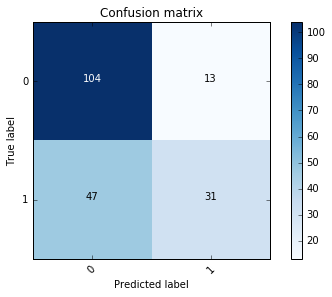

In [50]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes = sorted(y.unique()))

Which features did the model deem most "important" for predicting the target variable?

Note: Random forest models are considered "black box" models because they're hard to interpret.  If our model only had one decision tree instead of an entire forest of them, then we could examine the tree and see the exact criteria used to produce a prediction for any input.

In [51]:
# Show feature importances, highest first
pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_}).sort_values(
    by = 'importance', ascending = False)

,feature,importance
8,goout,0.126051
11,G3,0.091772
10,absences,0.070375
0,age,0.057088
13,sex,0.055358
9,health,0.050818
6,famrel,0.048003
17,reason,0.047736
7,freetime,0.047343
1,Medu,0.043254


### Next steps: Different ways to play around with random forests

- Tweak the random forest initialization parameters: change the number of decision trees
- Use a different set of features in X
- Predict a different variable (eg. student's test scores)
    - Use RandomForestRegressor instead of RandomForestClassifier to predict a variable that is numeric and continuous rather than categorical
- Transform a variable in a different way
- Use random forests's built-in out-of-bag error (oob score) to evaluate model performance

## Other resources

- Another random forest tutorial: [Random Forests in Python](http://blog.yhat.com/posts/random-forests-in-python.html)
- [Would You Survive the Titanic? A Guide to Machine Learning in Python](https://blog.socialcops.com/engineering/machine-learning-python/)
- [Supervised learning with scikit-learn](http://scikit-learn.org/stable/supervised_learning.html)